# PCA Amendments Drafts


This script integrates PCA Amendments Draft Geographies from multiple Shapefiles, onto a single dataset and exports to file


In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd

from utils import *

Info: Found credentials at: /Users/lelias/Library/CloudStorage/Box-Box/dvutils-creds-lelias.json
Admin ArcGIS client created


## Set variables

In [2]:
## Define the file download directories
dirs = [
    "MTC-ABAG SALC Planning Grant/8. Implementation/GIS_Amendment_Edits/Drafts",
    "MTC-ABAG SALC Planning Grant/8. Implementation/GIS_Amendment_Edits/Drafts/JurisdictionLedFiles"
]

status_list_dir = "MTC-ABAG SALC Planning Grant/8. Implementation/GIS_Amendment_Edits/Amendment_Status_1121.xlsx"

## Read Shapefiles and integrate to PCA Geographies

In [3]:
# Get a list of all shapefiles in the directories
shapefiles = shapefiles_list(dirs)
print(len(shapefiles))

# Read all shapefiles into a single GeoDataFrame
pca = read_shapefiles(shapefiles)

101


/Users/LElias/Documents/GH_repos/PCA-Refresh/utils.py:134: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gdf = gpd.GeoDataFrame(pd.concat(gdfs, ignore_index=True), crs=26910)


### Run Checks and additional fixes

<Axes: >

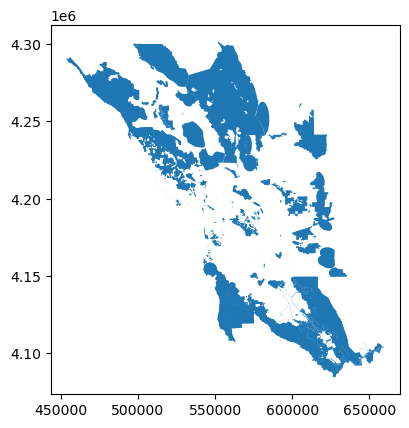

In [4]:
pca.plot()

### Apply Override

<Axes: >

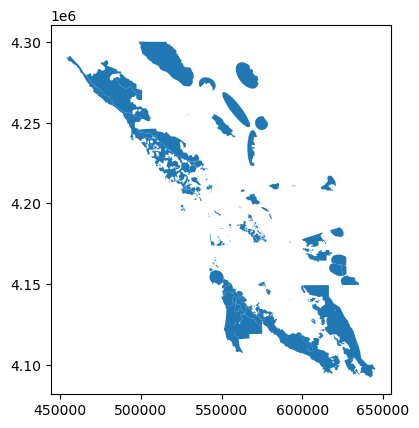

In [5]:
## Remove features from the PBA50_PCA_Polygons shapefile dataset
pca = pca[pca['source']!='PBA50_PCA_Polygons.shp']

pca.plot()

## Apply Table columns schema

In [6]:
## Define schema and transformations for the PCA shapefile attributes
columns_schema = [
    'joinkey', 'source', 'fipco', 'name', 'lead',
    'amend_stat', 'amend_lead',
    'typenl', 'typeal', 'typeug', 'typerr', 'typeca',
    'nomination_year', 'lastupdate', 'Version', 'Edit_Notes',
    'acres', 'INSIDE_X', 'INSIDE_Y', 'geometry'
    ]

columns_consolidate = {
    'amend_stat': ['Status_24', 'Status2024', 'Status24', 'Status_202'],
    'amend_lead': ['MapLead', 'Amend_Map_', 'Amend_Lead', 'Map_Lead']
    }

columns_rename = {
    'adopted': 'nomination_year'
    }

In [7]:
## Recalculate Geospatial attributes
print(pca.crs)
pca.loc[: , 'acres'] = pca.area / 4046.8564224
## Recalculate the centroid
# pca['INSIDE_X'] = pca.centroid.x
# pca['INSIDE_Y'] = pca.centroid.y
# pca['contains_point'] = pca.geometry.contains(pca.centroid)
# print(len(pca[pca['contains_point'] == False]))


EPSG:26910


In [8]:
## Rename columns
pca = pca.rename(columns=columns_rename)
## Fix NAN values
replace_nulls(pca, columns_consolidate['amend_stat']+columns_consolidate['amend_lead'])
print(pca[columns_consolidate['amend_stat']].describe())
print(pca[columns_consolidate['amend_lead']].describe())
## Consolidate columns
pca['amend_stat'] = pca['Status_24'].fillna(pca['Status2024']).fillna(pca['Status24']).fillna(pca['Status_202'])
pca['amend_lead'] = pca['MapLead'].fillna(pca['Amend_Map_']).fillna(pca['Amend_Lead']).fillna(pca['Map_Lead'])
## Drop columns
pca = pca[columns_schema]
pca.head()

       Status_24 Status2024 Status24 Status_202
count         94          1        2          3
unique         1          1        1          1
top        Draft      Draft    Draft      Draft
freq          94          1        2          3
       MapLead Amend_Map_ Amend_Lead Map_Lead
count        2          1          1      110
unique       1          1          1        2
top        MTC        MTC        MTC      MTC
freq         2          1          1       82


,joinkey,source,fipco,name,lead,amend_stat,amend_lead,typenl,typeal,typeug,typerr,typeca,nomination_year,lastupdate,Version,Edit_Notes,acres,INSIDE_X,INSIDE_Y,geometry
0,AL1,AL1_Draft.shp,06001,Leona Canyon Creek Tributaries,City of Oakland,Draft,MTC,0,0,0,1,1.0,2008,0,0,0,44.311692,-122.149872,37.787304,"POLYGON ((574709.805 4182765.007, 574741.328 4..."
1,AL22,AL22_Draft_2.shp,06001,Chain of Lakes Area,East Bay Regional Park District (EBRPD),Draft,MTC,1,0,0,0,1.0,2008,0,0,0,1450.789738,-121.838819,37.682917,"MULTIPOLYGON (((602890.288 4170039.009, 602885..."
2,AL24,AL24_Draft.shp,06001,Cedar Mountain Area,East Bay Regional Park District (EBRPD),Draft,MTC,1,0,0,0,1.0,2008,0,0,0,16399.417663,-121.613960,37.570924,"MULTIPOLYGON (((625158.673 4155010.536, 625024..."
3,AL25,AL25_Draft.shp,06001,Duarte Canyon Area,East Bay Regional Park District (EBRPD),Draft,MTC,1,0,0,0,1.0,2008,0,0,0,11956.889254,-121.540641,37.504374,"POLYGON ((629066.459 4154642.481, 629967.864 4..."
4,AL28,AL28_Draft2.shp,06001,Potential Tesla Area,East Bay Regional Park District (EBRPD),Draft,MTC,1,1,0,0,1.0,2008,0,0,0,12524.135768,-121.606700,37.621388,"POLYGON ((624385.673 4161227.404, 624305.630 4..."


In [9]:
def replace_nulls(df, columns, replace_dict=None):
    if replace_dict is None:
        replace_dict = {0: np.nan, '0': np.nan, 'nan': np.nan}
    df[columns] = df[columns].replace(replace_dict)




## Run some checks

In [10]:
pca[sorted(pca.columns)].sample(3).T

,256,43,247
Edit_Notes,0,0,0
INSIDE_X,0.0,-122.587456,0.0
INSIDE_Y,0.0,37.997542,0.0
Version,0,0,0
acres,704.263571,467.662006,14989.552979
amend_lead,Local Lead,MTC,Local Lead
amend_stat,NaN,Draft,NaN
fipco,06081,06041,06081
geometry,MULTIPOLYGON Z (((565020.7070000004 4140806.20...,MULTIPOLYGON (((536437.8180999998 4206332.6223...,POLYGON Z ((549983.0802999996 4157041.50159999...
joinkey,SM8,MR21,SM1


In [11]:
## Check for dups in joinkey
pca.groupby(['joinkey']).size().reset_index(name='parts').sort_values('parts', ascending=False)#.to_clipboard(index=False)

,joinkey,parts
81,SF106,3
17,AL8,3
64,SC34,2
90,SM10,2
34,MR11,2
...,...,...
33,MR10,1
32,DELETE,1
31,CC3,1
30,CC24,1


In [12]:
## Check for dups in source
pca.groupby(['source']).size().reset_index(name='parts').sort_values('parts', ascending=False)#.to_clipboard(index=False)

,source,parts
60,PCA_Midpen_2024Refresh_SanMateoCounty.shp,12
61,PCA_Midpen_2024Refresh_SantaClaraCounty.shp,9
62,Proposed_Amended_Priority_Conservation_Areas_S...,5
64,SC102_Draft.shp,1
73,SC38_Draft.shp,1
...,...,...
30,CC22_Draft.shp,1
29,CC21_Draft.shp,1
28,CC20_Draft.shp,1
27,CC19_Draft_2.shp,1


In [13]:
## Look at a specific joinkey 
pca[pca['joinkey']=='SF106']#.plot()

,joinkey,source,fipco,name,lead,amend_stat,amend_lead,typenl,typeal,typeug,typerr,typeca,nomination_year,lastupdate,Version,Edit_Notes,acres,INSIDE_X,INSIDE_Y,geometry
295,SF106,SF106_Draft.shp,06075,Lake Merced,City and County of San Francisco,Draft,MTC,0,0,0,1,0.0,2019,6/10/2021,0,0,1215.567804,-122.498596,37.728446,"POLYGON ((543517.469 4176605.761, 543548.555 4..."
296,SF106,SF106_E_Draft.shp,06075,Lake Merced,City and County of San Francisco,Draft,MTC,0,0,0,1,0.0,2019,6/10/2021,0,0,937.525425,-122.498596,37.728446,"POLYGON ((543815.790 4173948.777, 543617.049 4..."
297,SF106,SF106_W_Draft.shp,06075,Ocean Beach,City and County of San Francisco,Draft,MTC,0,0,0,1,1.0,2019,6/10/2021,0,0,278.042379,-122.498596,37.728446,"POLYGON ((543504.665 4176624.247, 543423.417 4..."


In [14]:
## Look at a specific joinkey
pca[pca['joinkey']=='SM1']#.plot()

,joinkey,source,fipco,name,lead,amend_stat,amend_lead,typenl,typeal,typeug,typerr,typeca,nomination_year,lastupdate,Version,Edit_Notes,acres,INSIDE_X,INSIDE_Y,geometry
247,SM1,PCA_Midpen_2024Refresh_SanMateoCounty.shp,06081,Montara Mountain Complex,Peninsula Open Space Trust,NaN,Local Lead,1,0,0,0,0.0,2008,0,0,0,14989.552979,0.0,0.0,"POLYGON Z ((549983.080 4157041.502 0.000, 5502..."


In [15]:
## Look at a specific source
# pca[pca['source']=='PCA_Midpen_2024Refresh_SanMateoCounty.shp']#.plot()

In [16]:
## Look at a specific source
# pca[pca['source']=='Proposed_Amended_Priority_Conservation_Areas_Sonoma_County_AOS_2024.shp']#.plot()

## Create Comparison Check List

In [17]:
## Status List will be used to filter the PCA datasets to be used for integration
## Open the Status List
status_list = pd.read_excel(os.path.join(box_path, status_list_dir))
## Filter the Status List to only include the datasets that should be run
status_list = status_list[(status_list['Run']=='Y')&(status_list['File name']!='[No changes]')]['File name']

## Clean-up the status list
## Remove the .shp extension
status_list = [item + '.shp' if not item.endswith('.shp') else item for item in status_list]
## Remove the 'See ' prefix
status_list = [itm.replace('See ', '') for itm in status_list]
## Remove duplicates
status_list = pd.DataFrame(status_list, columns=['status_list']).drop_duplicates()
print('Status List: ', len(status_list))

## Load List represents the actual PCA datasets that have been loaded for integration
load_list = pca[['source']].rename(columns={'source':'load_list'}).drop_duplicates()
print('Load List: ', len(load_list))

## Merge the Status List and Load List to check for completeness
check_list = pd.merge(status_list, load_list, left_on='status_list', right_on='load_list', how='outer').sort_values('load_list')

## Export the check list to a csv file
check_list.to_csv("_data/amendments_drafts/Amendment_Status_shp_check_list.csv", index=False)
check_list.to_clipboard()
check_list

Status List:  95
Load List:  100


,status_list,load_list
0,AL1_Draft.shp,AL1_Draft.shp
1,AL22_Draft_2.shp,AL22_Draft_2.shp
2,AL24_Draft.shp,AL24_Draft.shp
3,AL25_Draft.shp,AL25_Draft.shp
4,AL28_Draft2.shp,AL28_Draft2.shp
...,...,...
95,SF12_Draft.shp,SF12_Draft.shp
96,SF9_Draft.shp,SF9_Draft.shp
97,SM10_Draft.shp,SM10_Draft.shp
98,SM19_Draft.shp,SM19_Draft.shp


## Finalize Integrated PCA Amendments Draft dataset and export to files

In [18]:
## Filter the PCA datasets using the status list
pca_integrated = pca[pca['source'].isin(list(status_list['status_list']))].copy()
print('Integrated: ', len(pca_integrated))

Integrated:  110


In [19]:
## Export the integrated PCA dataset
# pca_integrated.to_csv("_data/amendments_drafts/pca_shp_integration_DRAFT.csv", index=Fa##lse)
pca_integrated.to_file("_data/amendments_drafts/GIS_Amendment_integration_DRAFT.shp", index=False)

/var/folders/s2/81kklxls0kb077vdkdq8jdv00000gp/T/ipykernel_83877/723367467.py:3: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  pca_integrated.to_file("_data/amendments_drafts/GIS_Amendment_integration_DRAFT.shp", index=False)


In [20]:
## Define the data types dictionary
data_types = {
    'nomination_year': 'int',
    'Version': 'str',
    'Edit_Notes': 'str',
    'amend_stat': 'str',
    'amend_lead': 'str',
    'lastupdate': 'str',
}

## Apply the data types to the DataFrame
pca_integrated = pca_integrated.astype(data_types)

## Export the integrated PCA dataset to a Feather file
pca_integrated.to_feather("_data/feather_files/pca_shp_integration.feather")

## Run some checks on finalized dataset

In [21]:
## Check for dups in joinkey
pca_integrated.groupby(['joinkey']).size().reset_index(name='parts').sort_values('parts', ascending=False)#.to_clipboard(index=False)

,joinkey,parts
80,SF106,2
45,MR7,2
11,AL33,2
89,SM10,2
17,AL8,2
...,...,...
33,MR10,1
32,DELETE,1
31,CC3,1
30,CC24,1


In [22]:
## Check for dups in source
pca_integrated.groupby(['source']).size().reset_index(name='parts').sort_values('parts', ascending=False)#.to_clipboard(index=False)

,source,parts
57,PCA_Midpen_2024Refresh_SanMateoCounty.shp,12
58,Proposed_Amended_Priority_Conservation_Areas_S...,5
0,AL1_Draft.shp,1
61,SC10_Draft.shp,1
69,SC38_Draft.shp,1
...,...,...
29,CC22_Draft.shp,1
28,CC21_Draft.shp,1
27,CC20_Draft.shp,1
26,CC19_Draft_2.shp,1
